# Inspecting condition differences using HsMM

There are several ways to estimate and inspect condition differences:
1. Estimate separate stage durations across conditions
2. Estimate separate event magnitudes across conditions
3. Estimate entirely different models for each condition

To illustrate these approaches we will rely on the same data as in Tutorial 1 and 3.

In [2]:
import os
import numpy as np
import xarray as xr
import hsmm_mvpy as hmp
from mne.io import read_info

cpus=3 #set the number of cores to use for all the code

epoch_data = xr.load_dataset(os.path.join('sample_data/sample_data.nc'))

#We create also the position array for the electrodes as we are going to need them to plot the event topologies
positions = read_info(os.path.join('sample_data/eeg/processed_0023_epo.fif'), verbose=False)

#And we transform as in the previous tutorial
hmp_data = hmp.utils.transform_data(epoch_data, apply_zscore='trial', n_comp=4)

## Applying HsMM to all conditions

For the two first applications we rely on a fit of HsMM on all the data, as shown in the previous tutorials.

In [3]:
init = hmp.models.hmp(hmp_data, sfreq=epoch_data.sfreq, cpus=cpus)

From the previous tutorial we know that we expect 4 events, so we re-estimate those with 100 random starting points.

  0%|          | 0/72 [00:00<?, ?it/s]

Transition event 1 found around sample 11
Transition event 2 found around sample 27
Transition event 3 found around sample 68
Estimating 3 events model
Parameters estimated for 3 events model


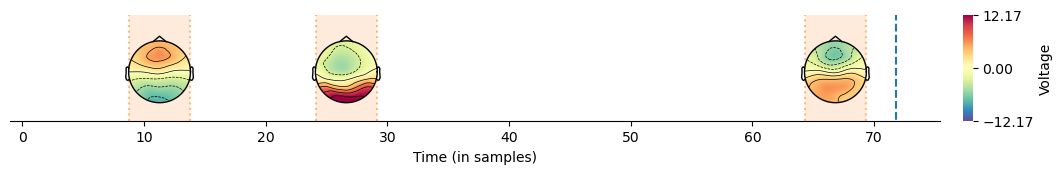

In [4]:
fit = init.fit()
hmp.visu.plot_topo_timecourse(epoch_data, fit, positions, init)

## 1. Estimate separate stage durations across speed conditions

In a design with a speed-accuracy trade-off such as this one, predictions on stages are rather straightforward. We expect that the main difference in latencies should be found in the decision stage (although there might be effects on other stages [Steinmann2018, Weindel2021]). To leave enough flexibility to the model we do not constrain the latencies to be fixed across conditions, but if we want to avoid extra degrees of freedom and test a hypothesis on a specific stage we can also fix stage durations as we do for magnitudes (see next application).

In [5]:
#select the conditions where participants needs to be fast
hmp_speed_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'SP', variable='cue')

#Here we turn off the estimation of magnitudes so only stage durations are free to vary
init_speed = hmp.models.hmp(hmp_speed_data,
                       sfreq=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

#select the conditions where participants needs to be fast
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'AC', variable='cue')
init_accuracy = hmp.models.hmp(hmp_accuracy_data,
                       sfreq=epoch_data.sfreq, cpus=cpus, estimate_magnitudes=False)

In [6]:
n_event = 3
speed = init_speed.fit_single(n_event, magnitudes=fit.magnitudes)#Having fixed magnitudes we need to pass those estimated from the previous iterative method
accuracy = init_accuracy.fit_single(n_event, magnitudes=fit.magnitudes)

Estimating 3 events model with 1 starting point(s)
Parameters estimated for 3 events model
Estimating 3 events model with 1 starting point(s)
Parameters estimated for 3 events model


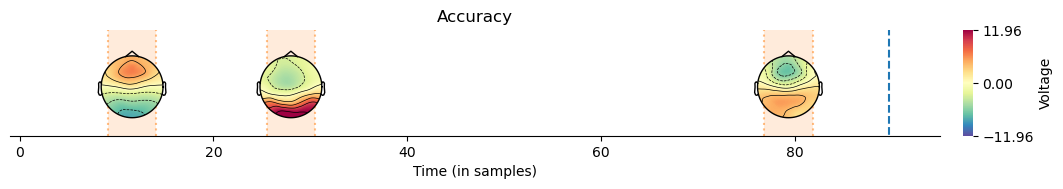

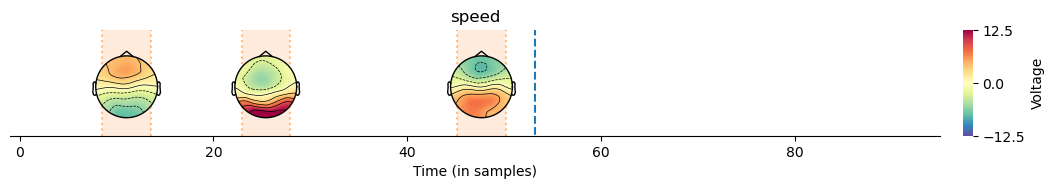

In [7]:
hmp.visu.plot_topo_timecourse(epoch_data, accuracy, positions, init_accuracy, title = 'Accuracy', max_time=95)
hmp.visu.plot_topo_timecourse(epoch_data, speed, positions, init_speed, title = 'speed', max_time=95)

We can now inspect the stage duration in a condition where participants are asked to speed up vs a condition where participant are asked to be accurate (thus slower)

In [8]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [speed, accuracy]):#Not very neat, to replace later
    condition_times.append(cond[0].compute_times(cond[0], cond[1], fill_value=0, add_rt=True))
condition_times = np.array(condition_times,dtype=object)


We can look at the average durations of the stages either with a bar chart

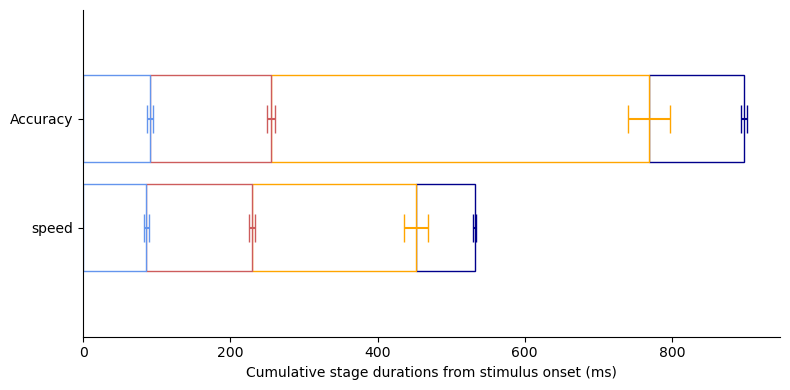

In [9]:
hmp.visu.plot_latencies_average(condition_times, time_step=1000/init.sfreq, 
                labels= ['speed', 'Accuracy'], errs='ci');

Or with a line plot

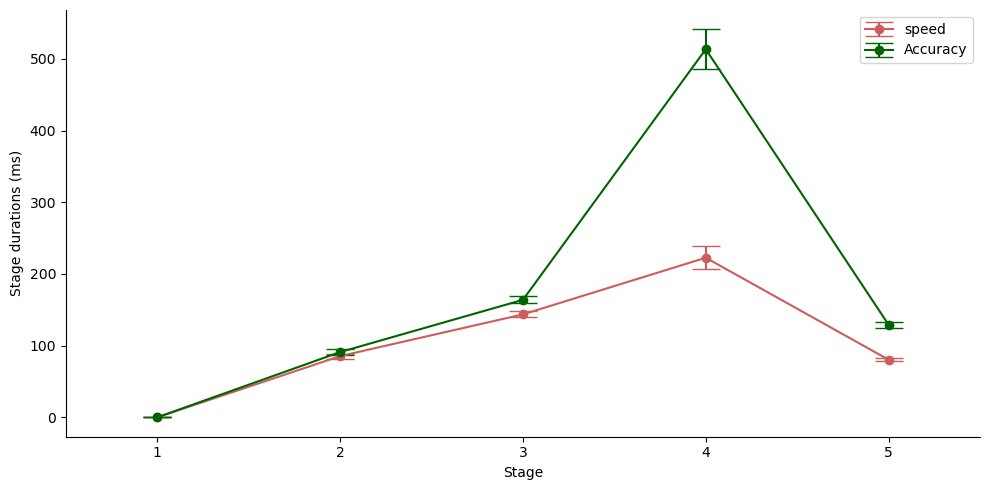

In [10]:
hmp.visu.plot_latencies(condition_times, kind='point',legend=True,
    labels= ['speed', 'Accuracy'], errs='ci', time_step=1000/init.sfreq,
    colors=["indianred","darkgreen"], figsize=(10,5));

Now applying the same model for conditions varying that much in speed might not be ideal and might hide important differences. It might be better to fit two independent models.

## 2. Estimate different topologies across conditions (left and right responses)

Given the conditions used in the dataset, it is hard to think of a difference in topologies arising from a condition where participants have to speed up *vs* a condition where they have to be accurate. A more interesting analysis regarding topologies would be looking at response side. We should be able to see a Lateralized Readiness Potential congruent with the response side, and as we expect this effect to be located on the event representing response execution we could choose to only estimate this on the last event.

In [11]:
epoch_data

<xarray.Dataset>
Dimensions:      (epochs: 200, channels: 30, samples: 197, participant: 4)
Coordinates:
  * epochs       (epochs) int64 0 1 2 3 4 5 6 7 ... 193 194 195 196 197 198 199
  * channels     (channels) object 'Fp1' 'Fp2' 'AFz' 'F7' ... 'CPz' 'CP2' 'CP6'
  * samples      (samples) int64 0 1 2 3 4 5 6 7 ... 190 191 192 193 194 195 196
    stim         (participant, epochs) float64 2.0 1.0 1.0 1.0 ... nan 2.0 1.0
    resp         (participant, epochs) object 'resp_left' ... 'resp_left'
    rt           (participant, epochs) float64 0.942 1.003 1.129 ... 0.392 0.376
    cue          (participant, epochs) object 'SP' 'AC' 'AC' ... '' 'SP' 'SP'
    movement     (participant, epochs) object 'stim_right' ... 'stim_left'
    trigger      (participant, epochs) object 'SP/stim_right/resp_left' ... '...
  * participant  (participant) object 'processed_0025_epo' ... 'processed_002...
Data variables:
    data         (participant, epochs, channels, samples) float64 2.891 ... nan
Attributes:
    sfreq:    100.0
    offset:   0

In [12]:
hmp_l_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'resp_left', variable='resp')
init_l = hmp.models.hmp(hmp_l_data,
                       sfreq=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

hmp_r_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'resp_right', variable='resp')
init_r = hmp.models.hmp(hmp_r_data,
                       sfreq=epoch_data.sfreq, cpus=cpus, estimate_parameters=False)

In [13]:

left_resp_estimates = init_l.fit_single(n_event, parameters=fit.parameters,magnitudes=fit.magnitudes, magnitudes_to_fix=[0,1])
right_resp_estimates = init_r.fit_single(n_event, parameters=fit.parameters,magnitudes=fit.magnitudes, magnitudes_to_fix=[0,1])

Estimating 3 events model
Parameters estimated for 3 events model
Estimating 3 events model
Parameters estimated for 3 events model


We can then use ```plot_topo_timecourse``` to display both fits.

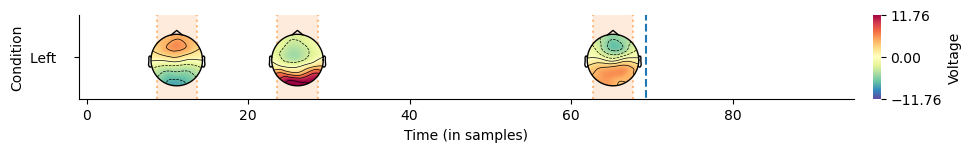

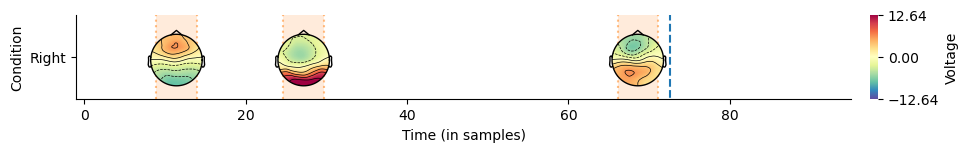

In [14]:
for condition in zip([left_resp_estimates, right_resp_estimates],
                     [init_l, init_r],
                     [hmp_l_data, hmp_r_data],
                    ['Left   ', 'Right']):
    hmp.visu.plot_topo_timecourse(epoch_data, condition[0], positions, condition[1], 
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),
                          max_time=95, figsize=(10,1), ylabels={'Condition':[condition[3]]})

Success, the last event changes with a (slight) shift in frontal negativity from left to right (likely LRPs but again, only four participants). We also note that right responses are slightly shifted on the time scale, this is an emergent property as even if we fix the gamma parameters of stage duration to be the same, the likeliest event location still spills on the estimation (and the RTs are different).

# 3. Estimate different models for each condition


As commented in section 1 estimating a single model for conditions with such a difference on stage durations is a bad idea as we enforce the stages of two very different conditions to be described by the same gamma distribution. A better idea in such case is to fit two separate models and compare those, additionally doing so will eventually reveal whether there is a difference in the number of events between the conditions.

So here we will fit two completely separate models to the two speed-accuracy conditions. This is the most flexible approach and requires enough data in each condition, it should however systematically been tested when there is a suspicion on a difference on number of stages as the two previous applications assumed the same number of stages. Here, we go with the results of [van Maanen et al. (2021)](https://link.springer.com/article/10.1007/s42113-021-00105-2), and estimate 3 events for the speed condition and 4 for accuracy.

### Applying HsMM separately for the speed condition

Initializing data for the speed condition

In [15]:
hmp_speed_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'SP', variable='cue')#select the conditions where participants needs to be fast
init_speed = hmp.models.hmp(hmp_speed_data,
                       sfreq=epoch_data.sfreq, cpus=cpus)

In [16]:
estimates_speed = init_speed.fit()

  0%|          | 0/53 [00:00<?, ?it/s]

Transition event 1 found around sample 12
Transition event 2 found around sample 27
Transition event 3 found around sample 49
Estimating 3 events model
Parameters estimated for 3 events model


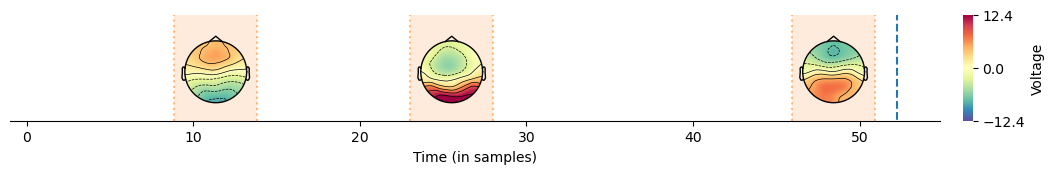

In [17]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_speed, positions, init_speed, 
                          times_to_display = np.mean(init_speed.ends - init_speed.starts))

  0%|          | 0/25 [00:00<?, ?it/s]

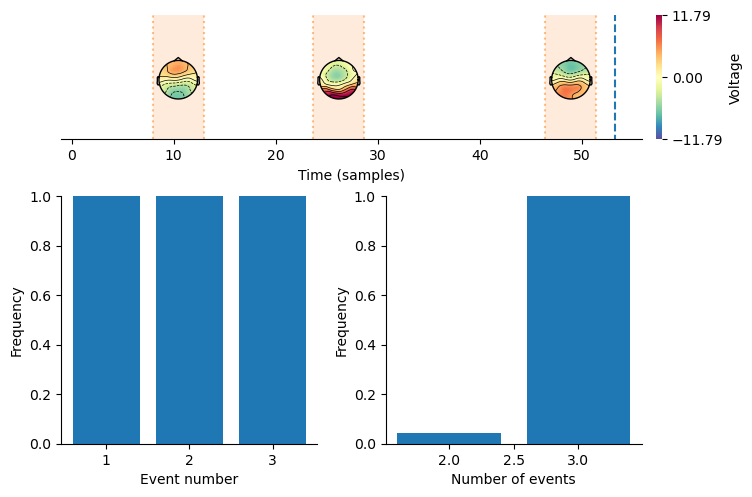

In [18]:
speed_epoch = epoch_data.where(epoch_data['cue'].str.contains('SP'), drop=True)
bootstrapped = hmp.resample.bootstrapping(data=speed_epoch, dim=['epochs','participant'], n_iterations=25, 
                                                 init=init_speed, positions=positions, sfreq=epoch_data.sfreq, cpus=cpus)

hmp.visu.plot_bootstrap_results(bootstrapped, positions, init_speed,
                               epoch_data = speed_epoch)

### Applying HsMM separately for the accuracy condition

Initializing data for the accuracy condition

In [19]:
hmp_accuracy_data = hmp.utils.condition_selection(hmp_data, epoch_data, 'AC', variable='cue')#select the conditions where participants needs to be fast
init_accuracy = hmp.models.hmp(hmp_accuracy_data,
                       sfreq=epoch_data.sfreq, cpus=cpus)

In [20]:
estimates_accuracy = init_accuracy.fit()

  0%|          | 0/90 [00:00<?, ?it/s]

Transition event 1 found around sample 12
Transition event 2 found around sample 28
Transition event 3 found around sample 48
Transition event 4 found around sample 85
Estimating 4 events model
Parameters estimated for 4 events model


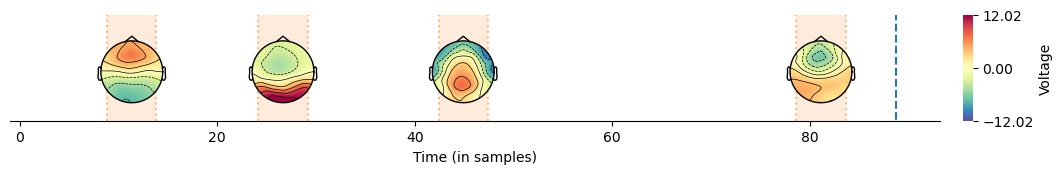

In [21]:
hmp.visu.plot_topo_timecourse(epoch_data, estimates_accuracy, positions, init_accuracy, 
                          times_to_display = np.mean(init_accuracy.ends - init_accuracy.starts))

  0%|          | 0/25 [00:00<?, ?it/s]

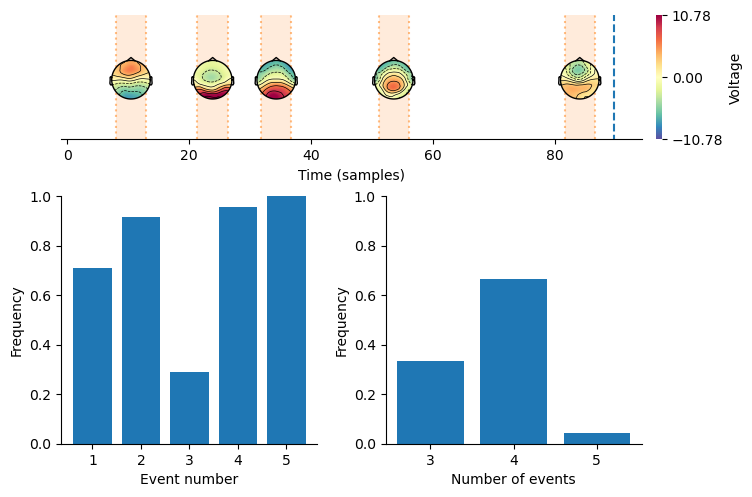

In [22]:
accuracy_epoch = epoch_data.where(epoch_data['cue'].str.contains('AC'),drop=True)
bootstrapped = hmp.resample.bootstrapping(data=accuracy_epoch, dim=['epochs','participant'], n_iterations=25, 
                                                 init=init_accuracy, positions=positions, sfreq=epoch_data.sfreq, cpus=cpus)

hmp.visu.plot_bootstrap_results(bootstrapped, positions, init_accuracy,
                               epoch_data = accuracy_epoch)

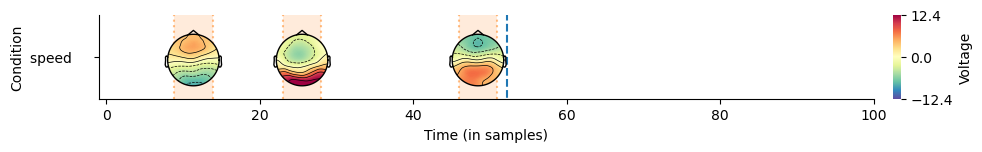

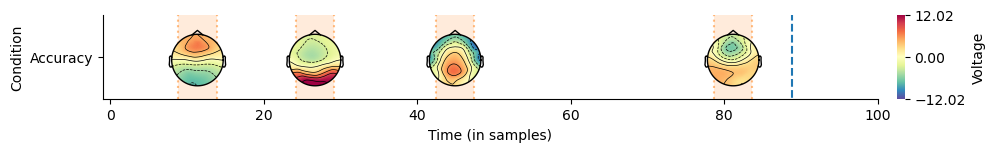

In [23]:
for condition in zip([estimates_speed, estimates_accuracy],
                     [init_speed, init_accuracy],
                     [hmp_speed_data, hmp_accuracy_data],
                    ['speed    ', 'Accuracy']):
    hmp.visu.plot_topo_timecourse(epoch_data, condition[0],
                          positions, condition[1],  
                          times_to_display = np.mean(condition[1].ends - condition[1].starts),max_time=100,
                          figsize=(10,1), ylabels={'Condition':[condition[3]]})

As well as the latencies of each stage

In [24]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):#Not very neat, to replace later
    condition_times.append(cond[0].compute_times(cond[0], cond[1].dropna('event'), fill_value=0, add_rt=True))
condition_times = np.array(condition_times,dtype=object)

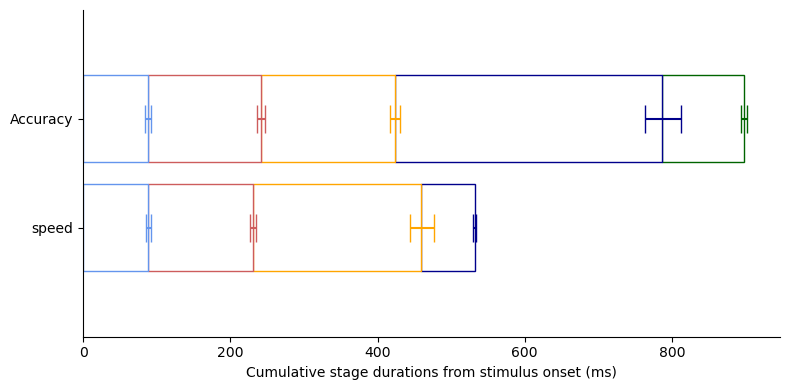

In [25]:
hmp.visu.plot_latencies_average(condition_times, time_step=1000/init.sfreq, 
                labels= ['speed', 'Accuracy'], errs='ci');

Or with a line plot

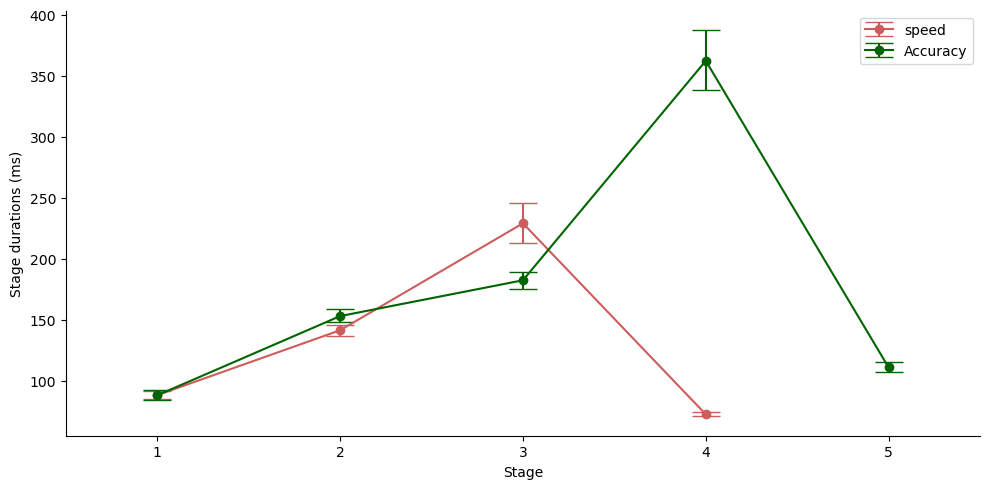

In [26]:
condition_times = []
for cond in zip([init_speed, init_accuracy],
                [estimates_speed, estimates_accuracy]):#Not very neat, to replace later
    condition_times.append(cond[0].compute_times(cond[0], cond[1].dropna('event'), add_rt=True))
condition_times = np.array(condition_times,dtype=object)
hmp.visu.plot_latencies(condition_times, kind='point',legend=True,
    labels= ['speed', 'Accuracy'], errs='ci', time_step=1000/init.sfreq,
    colors=["indianred","darkgreen"], figsize=(10,5));

And now we can describe our speed-accuracy manipulation in terms of stage number, stage duration and topologies!